In this notebook, we train an autoregressive PixelCNN to model our noise.


In [1]:
import os
import sys

import torch
from torchvision import transforms
from tifffile import imread
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
)
from pytorch_lightning.loggers import TensorBoardLogger

sys.path.append("../")
from noise_model.PixelCNN import PixelCNN
from utils.dataloaders import create_nm_loader
from utils.tools import view_receptive_field, autocorrelation

Load noise samples</br>
These should be numpy ndarrays of shape [Number, Channels, Height, Width] or [Number, Height, Width]. </br>
If working with 1-dimensional signals, the shape should be [Number, Channels, 1, Width] or [Number, 1, Width]


In [2]:
noise_location = "../data/conv/noise.tif"
noise = imread(noise_location)

Check spatial/temporal autocorrelation of noise. The recepetive field of the noise model doesn't have to span all pixels/timepoints correlated with each other, but should cover enough for an accurate model of the target pixel/timepoint.

If this function takes too long to execute, reduce the number of noise samples with `noise[:n]`.

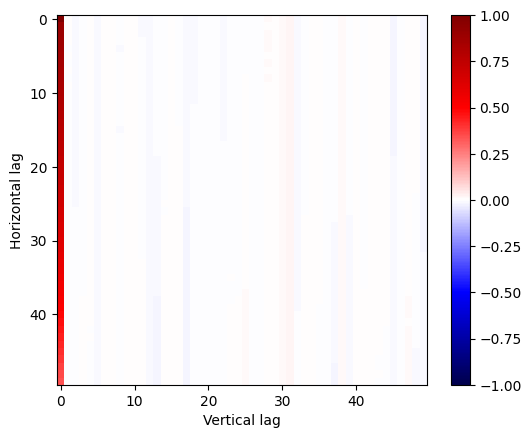

In [3]:
autocorrelation(noise, max_lag=50)

Create data loaders and get the mean and standard deviation of the noise samples.</br>
Use the transforms argument to apply a torchvision transformation to images as they are loaded. E.g. `transform = transforms.RandomCrop(64)`.


In [4]:
transform = None
nm_train_loader, nm_val_loader, noise_mean, noise_std = create_nm_loader(
    noise, batch_size=8, split=0.8, transform=transform
)

Set noise model checkpoint directory. This is where training logs and the trained model will be saved.


In [5]:
nm_checkpoint_path = "../nm_checkpoint/conv"

Initialise trainer and noise model.</br>

In [6]:
noise_model = PixelCNN(
    in_channels=1,
    n_gaussians=3,
    n_filters=128,
    kernel_size=5,
    depth=5,
    dropout=0,
    noise_mean=noise_mean,
    noise_std=noise_std,
    lr=1e-4,
)

use_cuda = torch.cuda.is_available()
trainer = pl.Trainer(
    default_root_dir=nm_checkpoint_path,
    accelerator="gpu" if use_cuda else "cpu",
    devices=1,
    max_epochs=500,
    logger=TensorBoardLogger(nm_checkpoint_path),
    log_every_n_steps=len(nm_train_loader),
    callbacks=[
        LearningRateMonitor(logging_interval="epoch"),
        EarlyStopping(patience=10, monitor="val/nll"),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


View how many pixels/timepoints the receptive field of the noise model will cover. Correlations within this range will be modelled while correlations outside this range will not. The autocorrelation plot can help to determine if enough pixels are included.</br>
For images, this shows the receptive field for the pixel in the bottom center of the image in yellow. For time series, this shows the receptive field of the last point in the series.</br>
Change the `kernel_size` to change the receptive field.

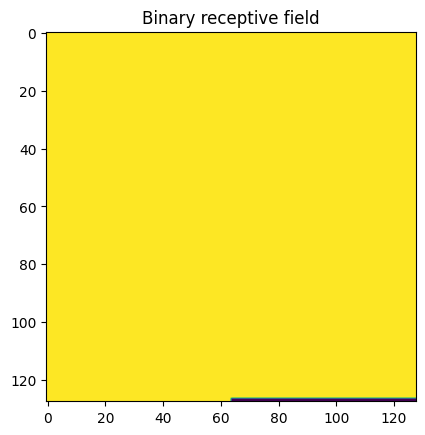

In [7]:
view_receptive_field(noise_model, noise.shape[-2:])

Train and save final parameters</br>
Training logs can be monitored on Tensorboard. Run the two cells below to activate it in the notebook. Alternatively, open a terminal, activate an environment with Tensorboard installed and enter `tensorboard --logdir path/to/autonoise/nm_checkpoint/` then open a browser and enter localhost:6006. 

The most important metric to monitor is the validation negative loglikelihood, or val/nll in Tensorboard. It should go down sharply at the start of training and slowly level off. Training should end when the loss has plateaued.</br>
The following are some scenarios where training goes wrong and suggestions on how to fix them.</br>
1. The validation loss goes down smoothly but training stops before it has plateaued.</br>
If training has stopped because the trainer hit 500 epochs, we can change the `max_epochs` value in the above cell to a higher number.
If training stopped before the trainer hit 500 epochs, we can change the `EarlyStopping(patience)` value in the above cell to a higher number.

2. The validation loss goes down smoothly then sharply increases.</br>
The model has overfit to the training data. Try the following fixes in this order: 
    * Increase `dropout` in the above cell to either 0.1 or 0.2. Higher than this is not recommended.
    * Decrease `depth` or `n_filters` to reduce the capacity of the network. Decreasing `depth` will also reduce the number of pixels or timepoints in the receptive field of the noise model, limiting its capacity to model long range correlations.
    * Train for fewer epochs or with a lower patience.

3. Validation loss does not go down smoothly or at all.
    * The learning rate is too high/low. Try changing `lr` by a factor of 10.
    * The batch size is too small/large. Try changing the `batch_size`in `create_nm_loader`. 
    * The number of Gaussians in the mixture model used for p(noise) is too high/low. Ideally, the `n_gaussians` variable should be set as low as possible to make training easier, but will need to be increased to describe complex noise. Try values from 1 to 10.


In [8]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ../nm_checkpoint

In [10]:
trainer.fit(noise_model, nm_train_loader, nm_val_loader)
trainer.save_checkpoint(os.path.join(nm_checkpoint_path, "final_params.ckpt"))

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type                  | Params
------------------------------------------------------
0 | up_inconv   | VerticalConvolution   | 3.3 K 
1 | left_inconv | HorizontalConvolution | 768   
2 | dropout     | Dropout               | 0     
3 | gatedconvs  | ModuleList            | 5.3 M 
4 | outconv     | Conv2d                | 1.2 K 
------------------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.338    Total estimated model params size (MB)


Epoch 311: 100%|██████████| 6/6 [00:01<00:00,  3.92it/s, v_num=4, val/nll=0.332] 
